# Long Short-Term Memory

## Initialization

### Import Libraries

In [2]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# TensorFlow / Keras Layers
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Label preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import f1_score

### Import Data

In [3]:
df_train = pd.read_csv('../dataset/train.csv', sep=',')
df_val = pd.read_csv('../dataset/valid.csv', sep=',')
df_test = pd.read_csv('../dataset/test.csv', sep=',')

In [4]:
label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

for df in [df_train, df_val, df_test]:
    df['label_id'] = df['label'].map(label_mapping)

    if df['label_id'].isnull().any():
        print("Warning: Some labels were not mapped! Check unique labels and label_mapping.")
        print(df[df['label_id'].isnull()])

x_train = np.array(df_train['text'])
y_train = np.array(df_train['label_id'])

x_val = np.array(df_val['text'])
y_val = np.array(df_val['label_id'])

x_test = np.array(df_test['text'])
y_test = np.array(df_test['label_id'])

In [5]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (500,), y_train shape: (500,)
x_val shape: (100,), y_val shape: (100,)
x_test shape: (400,), y_test shape: (400,)


## Preprocessing

Tokenized lengths: [16, 22, 6, 57, 5, 8, 6, 23, 8, 32, 77, 16, 43, 25, 47, 31, 19, 17, 9, 43, 23, 12, 37, 17, 12, 42, 12, 11, 37, 43, 7, 10, 24, 22, 13, 20, 15, 43, 28, 17, 43, 52, 36, 17, 8, 19, 28, 22, 22, 24, 7, 5, 15, 29, 15, 56, 27, 42, 11, 18, 36, 15, 19, 58, 7, 16, 7, 6, 8, 13, 15, 26, 20, 35, 6, 15, 27, 18, 47, 34, 24, 15, 41, 13, 10, 36, 15, 8, 20, 29, 23, 27, 35, 19, 33, 18, 40, 7, 33, 22, 17, 7, 18, 43, 20, 7, 49, 11, 63, 10, 11, 32, 18, 13, 46, 27, 29, 21, 42, 32, 21, 24, 49, 10, 56, 32, 30, 14, 16, 17, 19, 13, 40, 10, 9, 31, 14, 66, 23, 8, 33, 12, 26, 54, 18, 40, 30, 24, 7, 38, 57, 23, 24, 10, 19, 10, 21, 23, 18, 13, 17, 8, 58, 11, 27, 16, 13, 10, 43, 13, 30, 34, 23, 33, 6, 7, 22, 49, 7, 9, 6, 19, 41, 16, 38, 18, 14, 20, 17, 19, 28, 9, 31, 16, 27, 11, 54, 20, 50, 9, 9, 49, 9, 12, 20, 18, 46, 39, 15, 24, 24, 45, 13, 55, 11, 7, 7, 55, 41, 48, 30, 48, 24, 22, 59, 31, 23, 29, 54, 61, 29, 24, 56, 60, 6, 40, 41, 28, 8, 57, 16, 10, 19, 22, 22, 20, 28, 9, 55, 9, 19, 9, 50, 16, 9, 

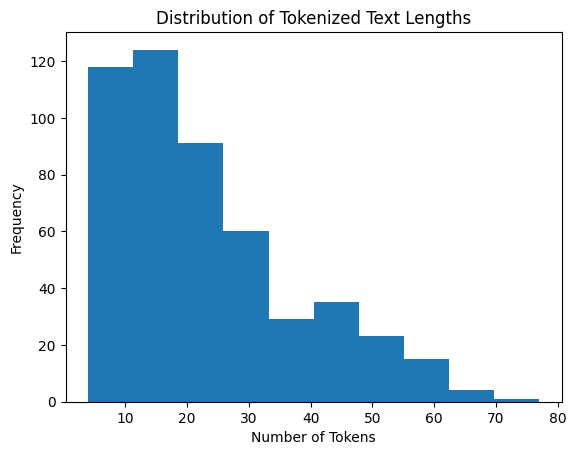

In [6]:
temp_vectorizer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)
temp_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(x_train))

tokenized_lengths = []
for text in x_train:
    tokens = temp_vectorizer([text]).numpy()[0]
    tokenized_lengths.append(np.count_nonzero(tokens))

print("Tokenized lengths:", tokenized_lengths)
print("Mean length:", np.mean(tokenized_lengths))
print("Median length:", np.median(tokenized_lengths))
print("Max length:", np.max(tokenized_lengths))
print("90th percentile:", np.percentile(tokenized_lengths, 90))
print("95th percentile:", np.percentile(tokenized_lengths, 95))

plt.hist(tokenized_lengths, bins=10)
plt.title('Distribution of Tokenized Text Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [7]:
vectorize_layer_full_vocab = layers.TextVectorization(
    max_tokens=None,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)

vectorize_layer_full_vocab.adapt(tf.data.Dataset.from_tensor_slices(x_train))

full_vocabulary = vectorize_layer_full_vocab.get_vocabulary()

print(f"Total unique tokens (including OOV if present): {len(full_vocabulary)}")
print("Top 20 most frequent tokens:", full_vocabulary[:20])
print("Some of the least frequent tokens:", full_vocabulary[-20:])

Total unique tokens (including OOV if present): 2836
Top 20 most frequent tokens: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini'), np.str_('makan'), np.str_('untuk'), np.str_('ke'), np.str_('tempat'), np.str_('makanan'), np.str_('juga'), np.str_('sangat'), np.str_('ada'), np.str_('banyak'), np.str_('karena')]
Some of the least frequent tokens: [np.str_('360'), np.str_('2x'), np.str_('2baso'), np.str_('2910'), np.str_('270'), np.str_('25000'), np.str_('250'), np.str_('2012'), np.str_('2002'), np.str_('1996'), np.str_('190000'), np.str_('18'), np.str_('1748'), np.str_('16'), np.str_('15000'), np.str_('150'), np.str_('14000'), np.str_('120'), np.str_('12'), np.str_('1000')]


### Preprocessing Result
Since the number of unique tokens is not significantly large, we will use (2836+1) **2837 as the vocabulary size** (max_tokens) and take the 95th percentile value of **54 as the output_sequence_length**

In [8]:
MAX_TOKENS = 2837
OUTPUT_SEQUENCE_LENGTH = 54
EMBEDDING_DIM = 64
NUM_CLASSES = 3

MODEL_SAVE_DIR = '../bin/lstm_models'
PLOT_SAVE_DIR = '../bin/lstm_plots'

In [9]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

In [10]:
text_vectorization_layer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH
)

text_vectorization_layer.adapt(tf.data.Dataset.from_tensor_slices(x_train))

## Training and Prediction

### Boilerplate Functions

In [11]:
def calculate_macro_f1(y_true, y_pred_classes):
    return f1_score(y_true, y_pred_classes, average='macro')

def plot_training_history(history, title, filename):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_SAVE_DIR, filename))
    plt.show()
    plt.close()

In [12]:
def build_lstm_model(num_lstm_layers=1, lstm_units=64, lstm_direction='unidirectional', num_classes=NUM_CLASSES):
    model = models.Sequential()

    model.add(layers.Input(shape=(1,), dtype=tf.string))
    model.add(text_vectorization_layer)
    model.add(layers.Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
        mask_zero=True,
    ))

    for i in range(num_lstm_layers):
        return_sequences = (i < num_lstm_layers - 1)

        if lstm_direction == 'unidirectional':
            model.add(layers.LSTM(lstm_units, return_sequences=return_sequences))
        elif lstm_direction == 'bidirectional':
            model.add(layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=return_sequences)))
        else:
            raise ValueError("lstm_direction must be 'unidirectional' or 'bidirectional'")

        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [13]:
def train_and_evaluate_model(model_name, model_params, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
    print(f"\n--- Training Model: {model_name} ---")
    model = build_lstm_model(**model_params)
    model.summary()

    # Define callbacks
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure directory exists
    best_model_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name}_best_val_loss.h5')
    end_of_training_model_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name}_end_of_training.h5')


    checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=best_model_filepath,
        save_weights_only=False,  # MUST BE False to create 'model_weights' group
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0
    )
    early_stopping_callback = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=False, # CHANGED: Set to False
        verbose=0
    )

    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, early_stopping_callback],
        verbose=1
    )

    model.save(end_of_training_model_filepath)
    print(f"End-of-training Keras model saved to: {end_of_training_model_filepath}")
    print(f"Best Keras model (based on val_loss) was saved to: {best_model_filepath}")

    plot_title = f"{model_name}"
    # You'll need to ensure plot_filename includes a valid path or that MODEL_SAVE_DIR is appropriate
    plot_filename_path = f"{model_name}_loss_accuracy.png"
    plot_training_history(history, plot_title, plot_filename_path)

    # These predictions will be based on the model state at the end of fit()
    y_val_pred_probs = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred_probs, axis=1)

    y_test_pred_probs = model.predict(x_test)
    y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)

    return history, y_val_pred_classes, y_test_pred_classes

In [14]:
def evaluate_macro_f1(y_true, y_pred, dataset_name="Validation"):
    """
    Calculates and prints the macro F1-score.
    """
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1-score on {dataset_name} set: {macro_f1:.4f}")
    return macro_f1

### Variation in Number of LSTM Layers


--- Training Model: LSTM_Layers_1 ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,787 (839.01 KB)

 Trainable params: 214,787 (839.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3827 - loss: 1.0920

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.3846 - loss: 1.0916 - val_accuracy: 0.5300 - val_loss: 1.0637
Epoch 2/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4863 - loss: 1.0105

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4832 - loss: 1.0081 - val_accuracy: 0.4200 - val_loss: 0.9873
Epoch 3/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6232 - loss: 0.8193

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6320 - loss: 0.8185 - val_accuracy: 0.7400 - val_loss: 0.8727
Epoch 4/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9236 - loss: 0.6359

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9222 - loss: 0.6252 - val_accuracy: 0.7300 - val_loss: 0.7949
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9256 - loss: 0.3273 - val_accuracy: 0.7200 - val_loss: 0.8078
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9752 - loss: 0.1952 - val_accuracy: 0.7300 - val_loss: 0.8088
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9809 - loss: 0.1019 - val_accuracy: 0.7200 - val_loss: 0.8454
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9947 - loss: 0.0460 - val_accuracy: 0.6900 - val_loss: 0.9589
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9990 - loss: 0.0264 - val_accuracy: 0.7100 - val_loss: 1.0428


End-of-training Keras model saved to: ../bin/lstm_models\LSTM_Layers_1_end_of_training.h5
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Layers_1_best_val_loss.h5


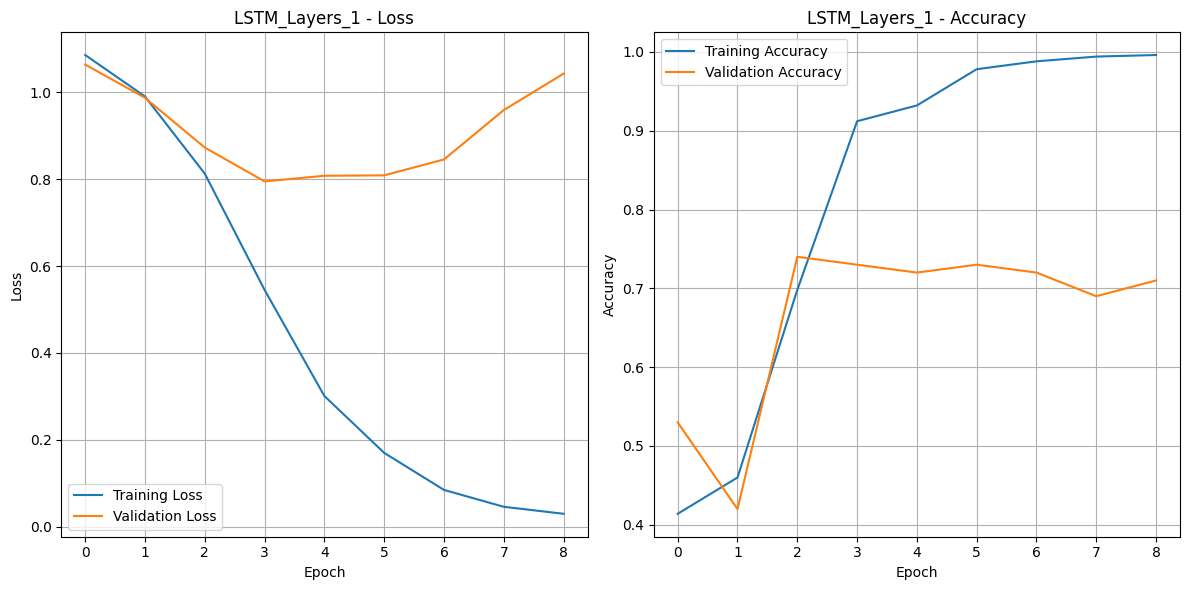

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Macro F1-score on Validation set: 0.6968
Macro F1-score on Test set: 0.7129

--- Training Model: LSTM_Layers_2 ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,811 (968.01 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3973 - loss: 1.0876

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.3983 - loss: 1.0866 - val_accuracy: 0.3800 - val_loss: 1.0279
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4345 - loss: 0.9654

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.4378 - loss: 0.9636 - val_accuracy: 0.6100 - val_loss: 0.9192
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7620 - loss: 0.7077

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7647 - loss: 0.7037 - val_accuracy: 0.6800 - val_loss: 0.8291
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9427 - loss: 0.3564

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9427 - loss: 0.3535 - val_accuracy: 0.7700 - val_loss: 0.7581
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9689 - loss: 0.1483 - val_accuracy: 0.7600 - val_loss: 0.8487
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9910 - loss: 0.0697 - val_accuracy: 0.7500 - val_loss: 0.9644
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9979 - loss: 0.0295 - val_accuracy: 0.7400 - val_loss: 1.0969
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9995 - loss: 0.0139 - val_accuracy: 0.7400 - val_loss: 1.2234
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9975 - loss: 0.0121 - val_accuracy: 0.7400 - val_loss: 1.3065


End-of-training Keras model saved to: ../bin/lstm_models\LSTM_Layers_2_end_of_training.h5
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Layers_2_best_val_loss.h5


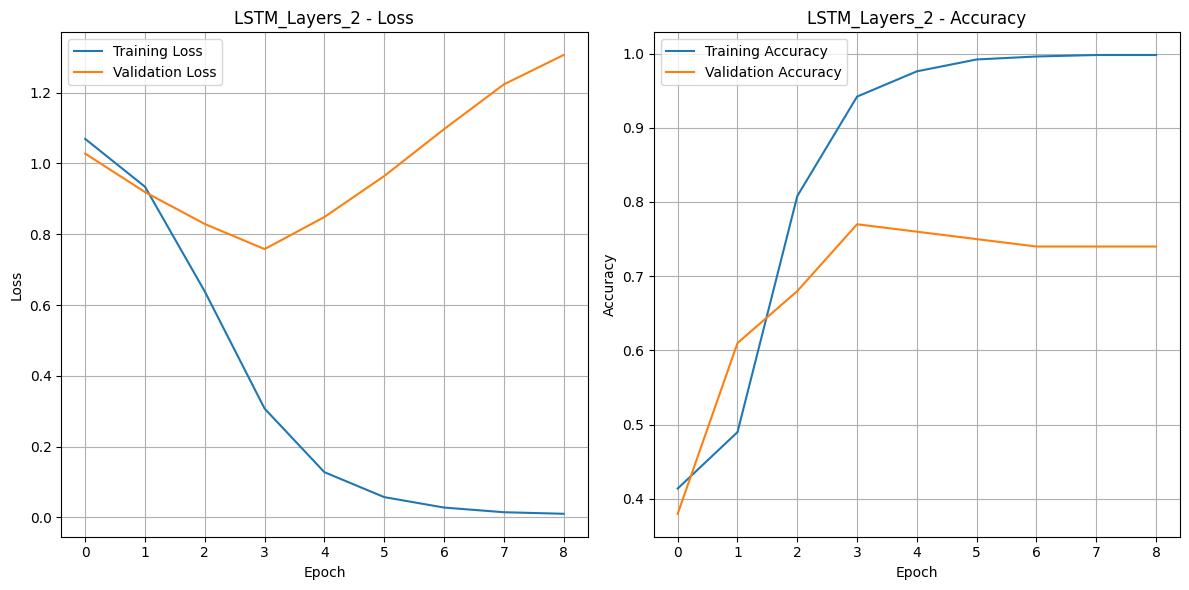

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Macro F1-score on Validation set: 0.7352
Macro F1-score on Test set: 0.7215

--- Training Model: LSTM_Layers_3 ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,835 (1.07 MB)

 Trainable params: 280,835 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4174 - loss: 1.0819

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.4169 - loss: 1.0808 - val_accuracy: 0.3800 - val_loss: 1.0350
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5102 - loss: 0.9379

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.5153 - loss: 0.9345 - val_accuracy: 0.6400 - val_loss: 0.8456
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.6948 - loss: 0.6212 - val_accuracy: 0.5700 - val_loss: 0.8467
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.8299 - loss: 0.4511 - val_accuracy: 0.7500 - val_loss: 0.8542
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9650 - loss: 0.2231 - val_accuracy: 0.6900 - val_loss: 1.1298
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9671 - loss: 0.1472 - val_accuracy: 0.7100 - val_loss: 1.0392
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9911 - loss: 0.0613 - val_accuracy: 0.7400 - val_loss: 0.9883


End-of-training Keras model saved to: ../bin/lstm_models\LSTM_Layers_3_end_of_training.h5
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Layers_3_best_val_loss.h5


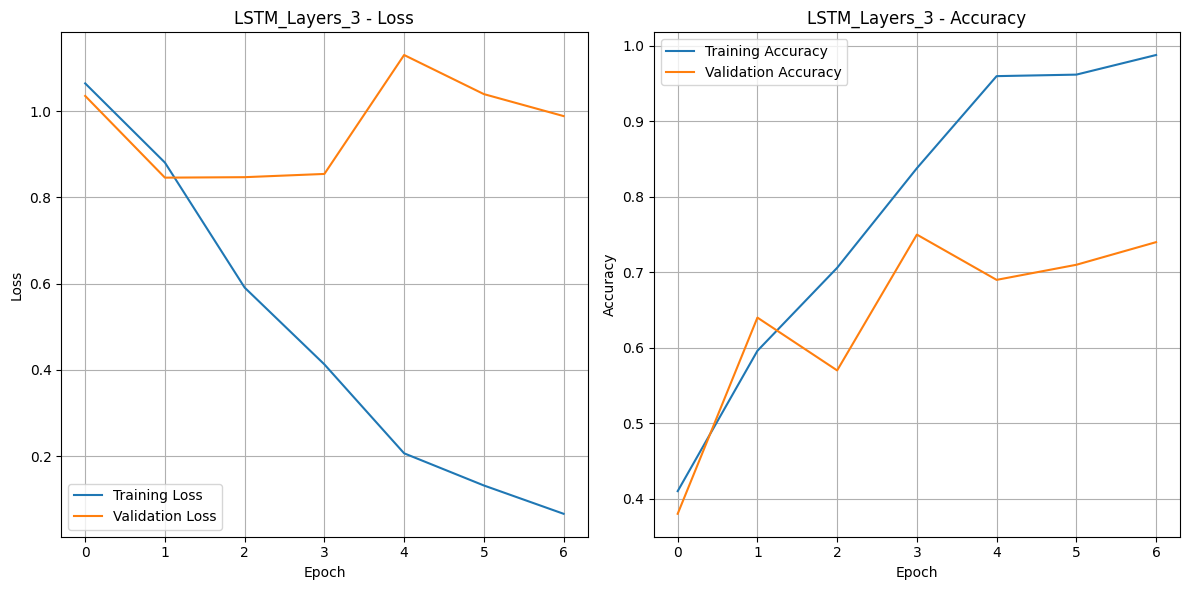

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Macro F1-score on Validation set: 0.7328
Macro F1-score on Test set: 0.6962

--- Summary: Pengaruh jumlah layer LSTM ---
LSTM_Layers_1: Validation Macro F1 = 0.6968, Test Macro F1 = 0.7129
LSTM_Layers_2: Validation Macro F1 = 0.7352, Test Macro F1 = 0.7215
LSTM_Layers_3: Validation Macro F1 = 0.7328, Test Macro F1 = 0.6962


In [15]:
lstm_layer_variations = [1, 2, 3]

results_layer_count = {}

for num_layers in lstm_layer_variations:
    model_params = {
        'num_lstm_layers': num_layers,
        'lstm_units': 64,
        'lstm_direction': 'unidirectional'
    }
    model_name = f"LSTM_Layers_{num_layers}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_layer_count[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh jumlah layer LSTM ---")
for name, res in results_layer_count.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")


### Variation in Number of LSTM Cells


--- Training Model: LSTM_Units_32 ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 54, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 54, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,403 (790.64 KB)

 Trainable params: 202,403 (790.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3548 - loss: 1.0918

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.3558 - loss: 1.0911 - val_accuracy: 0.3800 - val_loss: 1.0438
Epoch 2/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3862 - loss: 1.0001

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3902 - loss: 0.9953 - val_accuracy: 0.5400 - val_loss: 0.9327
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6851 - loss: 0.7894

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6868 - loss: 0.7871 - val_accuracy: 0.6300 - val_loss: 0.8520
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7474 - loss: 0.5637

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7478 - loss: 0.5608 - val_accuracy: 0.6400 - val_loss: 0.8319
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9246 - loss: 0.3483

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9256 - loss: 0.3458 - val_accuracy: 0.7500 - val_loss: 0.7529
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9806 - loss: 0.2007 - val_accuracy: 0.7600 - val_loss: 0.8094
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9918 - loss: 0.1035 - val_accuracy: 0.7700 - val_loss: 0.9124
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9979 - loss: 0.0476 - val_accuracy: 0.7600 - val_loss: 0.9661
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9984 - loss: 0.0291 - val_accuracy: 0.7600 - val_loss: 1.0493
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9964 - loss: 0.0259 - val_accuracy: 0.7500 - val_loss: 1.1248


End-of-training Keras model saved to: ../bin/lstm_models\LSTM_Units_32_end_of_training.h5
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Units_32_best_val_loss.h5


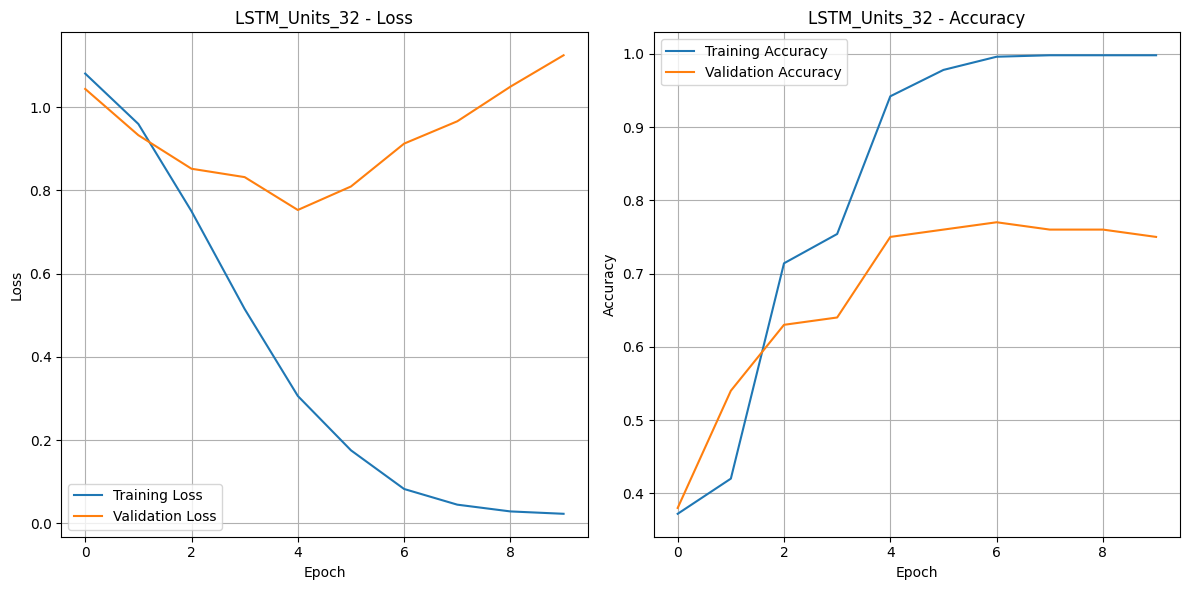

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Macro F1-score on Validation set: 0.7418
Macro F1-score on Test set: 0.7306

--- Training Model: LSTM_Units_64 ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,811 (968.01 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4092 - loss: 1.0831

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.4071 - loss: 1.0823 - val_accuracy: 0.4000 - val_loss: 1.0091
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5238 - loss: 0.9264

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.5269 - loss: 0.9251 - val_accuracy: 0.6400 - val_loss: 0.9074
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7242 - loss: 0.7181

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.7260 - loss: 0.7144 - val_accuracy: 0.5900 - val_loss: 0.8723
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7413 - loss: 0.5131

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.7430 - loss: 0.5105 - val_accuracy: 0.6300 - val_loss: 0.8190
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9345 - loss: 0.2766 - val_accuracy: 0.6900 - val_loss: 1.0452
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9745 - loss: 0.1745 - val_accuracy: 0.7100 - val_loss: 0.9691
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9933 - loss: 0.0771 - val_accuracy: 0.7100 - val_loss: 1.0448
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9904 - loss: 0.0514 - val_accuracy: 0.7300 - val_loss: 0.9134
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9946 - loss: 0.0383 - val_accuracy: 0.7300 - val_loss: 1.1093


End-of-training Keras model saved to: ../bin/lstm_models\LSTM_Units_64_end_of_training.h5
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Units_64_best_val_loss.h5


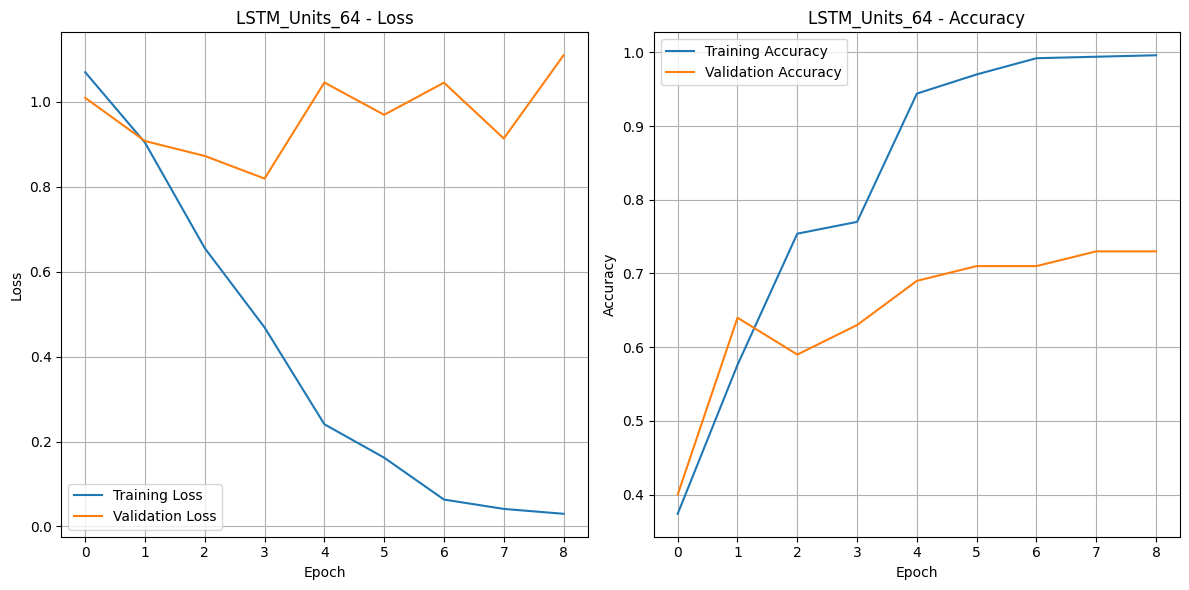

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Macro F1-score on Validation set: 0.7260
Macro F1-score on Test set: 0.7241

--- Training Model: LSTM_Units_128 ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 54, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,355 (1.57 MB)

 Trainable params: 412,355 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3935 - loss: 1.0779

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.3964 - loss: 1.0756 - val_accuracy: 0.5400 - val_loss: 0.9949
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5279 - loss: 0.9192

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5328 - loss: 0.9160 - val_accuracy: 0.7000 - val_loss: 0.8743
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8541 - loss: 0.5543

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.8544 - loss: 0.5511 - val_accuracy: 0.7000 - val_loss: 0.7385
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9303 - loss: 0.3036 - val_accuracy: 0.6800 - val_loss: 1.0415
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9685 - loss: 0.1207 - val_accuracy: 0.6800 - val_loss: 0.9707
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9730 - loss: 0.0975 - val_accuracy: 0.7300 - val_loss: 0.8938
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9923 - loss: 0.0420 - val_accuracy: 0.7100 - val_loss: 1.2142
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9987 - loss: 0.0121 - val_accuracy: 0.7000 - val_loss: 1.3600


End-of-training Keras model saved to: ../bin/lstm_models\LSTM_Units_128_end_of_training.h5
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Units_128_best_val_loss.h5


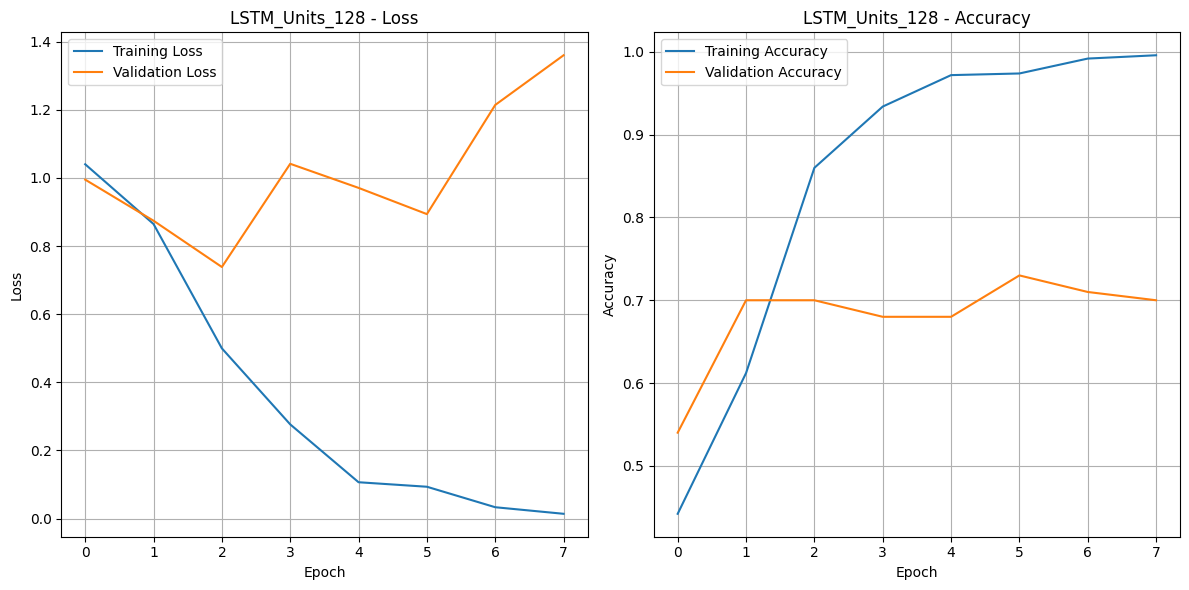

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Macro F1-score on Validation set: 0.6860
Macro F1-score on Test set: 0.7087

--- Summary: Pengaruh banyak cell LSTM per layer ---
LSTM_Units_32: Validation Macro F1 = 0.7418, Test Macro F1 = 0.7306
LSTM_Units_64: Validation Macro F1 = 0.7260, Test Macro F1 = 0.7241
LSTM_Units_128: Validation Macro F1 = 0.6860, Test Macro F1 = 0.7087


In [16]:
lstm_units_variations = [32, 64, 128]

results_units = {}

for units in lstm_units_variations:
    model_params = {
        'num_lstm_layers': 2,
        'lstm_units': units,
        'lstm_direction': 'unidirectional'
    }
    model_name = f"LSTM_Units_{units}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_units[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh banyak cell LSTM per layer ---")
for name, res in results_units.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")

### Variation in LSTM Layer Direction


--- Training Model: LSTM_Direction_unidirectional ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,811 (968.01 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4331 - loss: 1.0776

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.4350 - loss: 1.0756 - val_accuracy: 0.3900 - val_loss: 1.0821
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5030 - loss: 0.9302

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5067 - loss: 0.9284 - val_accuracy: 0.6200 - val_loss: 0.8649
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7165 - loss: 0.6498

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7160 - loss: 0.6472 - val_accuracy: 0.6100 - val_loss: 0.8263
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8728 - loss: 0.3863 - val_accuracy: 0.6400 - val_loss: 1.0746
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9533 - loss: 0.1988 - val_accuracy: 0.7400 - val_loss: 1.0422
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9876 - loss: 0.0852 - val_accuracy: 0.6900 - val_loss: 1.2212
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9930 - loss: 0.0384 - val_accuracy: 0.7500 - val_loss: 1.0486
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9897 - loss: 0.0395 - val_accuracy: 0.7000 - val_loss: 1.3450


End-of-training Keras model saved to: ../bin/lstm_models\LSTM_Direction_unidirectional_end_of_training.h5
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Direction_unidirectional_best_val_loss.h5


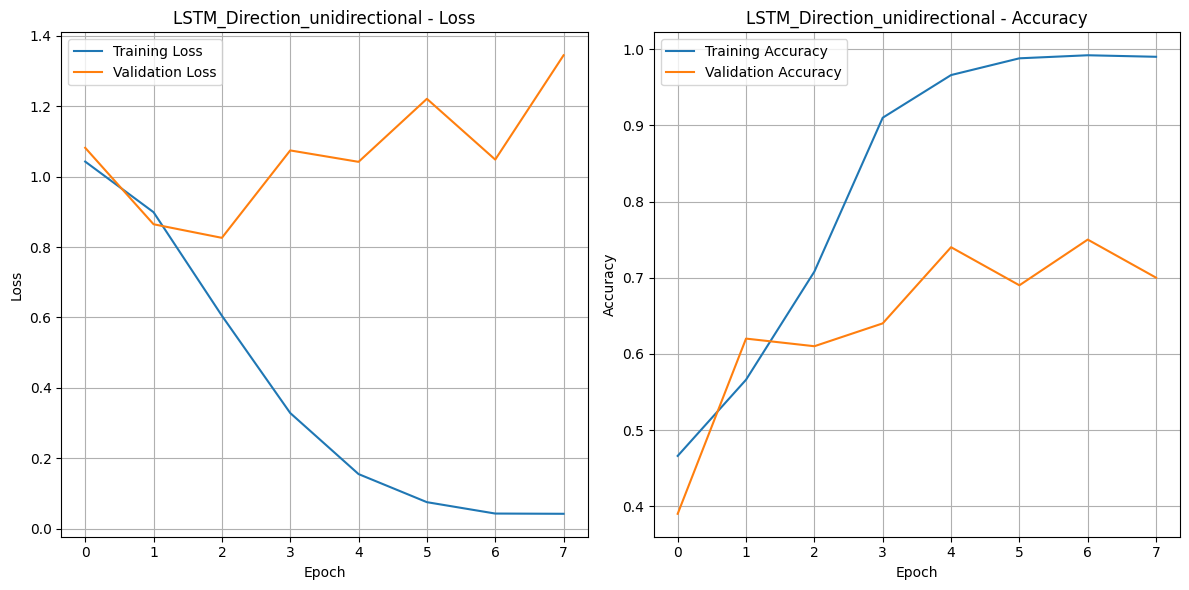

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Macro F1-score on Validation set: 0.6950
Macro F1-score on Test set: 0.6951

--- Training Model: LSTM_Direction_bidirectional ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 54, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,819 (1.32 MB)

 Trainable params: 346,819 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3891 - loss: 1.0858

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - accuracy: 0.3890 - loss: 1.0852 - val_accuracy: 0.3900 - val_loss: 1.0283
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4977 - loss: 0.9395

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5016 - loss: 0.9365 - val_accuracy: 0.6100 - val_loss: 0.8477
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7334 - loss: 0.5501 - val_accuracy: 0.7600 - val_loss: 0.8482
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9612 - loss: 0.2905 - val_accuracy: 0.7300 - val_loss: 0.9186
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9795 - loss: 0.1085 - val_accuracy: 0.7800 - val_loss: 0.9256
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9943 - loss: 0.0547 - val_accuracy: 0.7900 - val_loss: 0.8571
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9903 - loss: 0.0370 - val_accuracy: 0.7700 - val_loss: 1.0287


End-of-training Keras model saved to: ../bin/lstm_models\LSTM_Direction_bidirectional_end_of_training.h5
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Direction_bidirectional_best_val_loss.h5


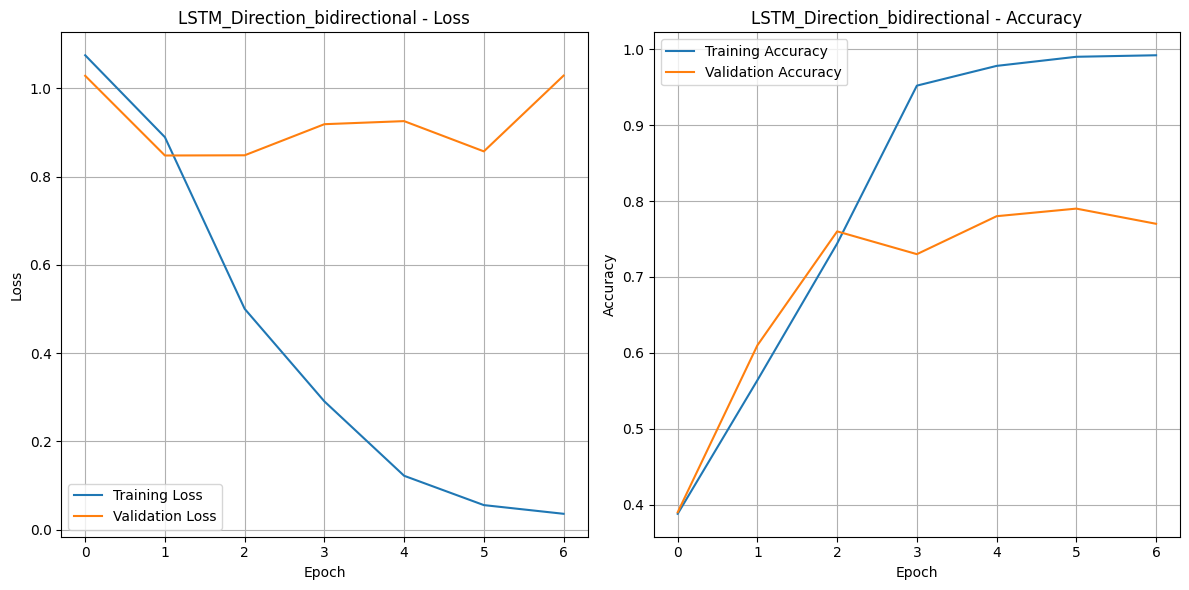

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Macro F1-score on Validation set: 0.7667
Macro F1-score on Test set: 0.7272

--- Summary: Pengaruh jenis layer LSTM berdasarkan arah ---
LSTM_Direction_unidirectional: Validation Macro F1 = 0.6950, Test Macro F1 = 0.6951
LSTM_Direction_bidirectional: Validation Macro F1 = 0.7667, Test Macro F1 = 0.7272


In [17]:
lstm_direction_variations = ['unidirectional', 'bidirectional']

results_direction = {}

for direction in lstm_direction_variations:
    model_params = {
        'num_lstm_layers': 2,
        'lstm_units': 64,
        'lstm_direction': direction
    }
    model_name = f"LSTM_Direction_{direction}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_direction[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh jenis layer LSTM berdasarkan arah ---")
for name, res in results_direction.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")

### Overall Analysis and Conclusions

In [18]:
# Helper function to print conclusions clearly
def print_conclusion(experiment_name, results_dict):
    print(f"\n--- {experiment_name} ---")
    best_val_f1 = -1
    best_model_name = ""
    for name, res in results_dict.items():
        print(f"{name}: Val Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")
        if res['val_macro_f1'] > best_val_f1:
            best_val_f1 = res['val_macro_f1']
            best_model_name = name
    print(f"Best performing model in this experiment (based on Validation F1): {best_model_name} (F1: {best_val_f1:.4f})")

print_conclusion("Pengaruh jumlah layer LSTM", results_layer_count)
print_conclusion("Pengaruh banyak cell LSTM per layer", results_units)
print_conclusion("Pengaruh jenis layer LSTM berdasarkan arah", results_direction)


--- Pengaruh jumlah layer LSTM ---
LSTM_Layers_1: Val Macro F1 = 0.6968, Test Macro F1 = 0.7129
LSTM_Layers_2: Val Macro F1 = 0.7352, Test Macro F1 = 0.7215
LSTM_Layers_3: Val Macro F1 = 0.7328, Test Macro F1 = 0.6962
Best performing model in this experiment (based on Validation F1): LSTM_Layers_2 (F1: 0.7352)

--- Pengaruh banyak cell LSTM per layer ---
LSTM_Units_32: Val Macro F1 = 0.7418, Test Macro F1 = 0.7306
LSTM_Units_64: Val Macro F1 = 0.7260, Test Macro F1 = 0.7241
LSTM_Units_128: Val Macro F1 = 0.6860, Test Macro F1 = 0.7087
Best performing model in this experiment (based on Validation F1): LSTM_Units_32 (F1: 0.7418)

--- Pengaruh jenis layer LSTM berdasarkan arah ---
LSTM_Direction_unidirectional: Val Macro F1 = 0.6950, Test Macro F1 = 0.6951
LSTM_Direction_bidirectional: Val Macro F1 = 0.7667, Test Macro F1 = 0.7272
Best performing model in this experiment (based on Validation F1): LSTM_Direction_bidirectional (F1: 0.7667)


## Forward Pass Comparison

### Best Model Based on Validation

In [23]:
model_filepath_to_load = f"{MODEL_SAVE_DIR}/LSTM_Direction_bidirectional_end_of_training.h5"

In [20]:
import importlib
import sys

# --- Modules to Reload ---
# List them in an order that makes sense for dependencies, if known.
# Base classes first, then classes that use them.
# Your 'layers.layer' and 'layers.rnn' are base classes.
module_paths = {
    "LayerBase": "layers.layer", # Assuming your Layer class is in layers.layer
    "RNNBase": "layers.rnn",     # Assuming your RNN class is in layers.rnn
    "TextVectorizationWrapper": "layers.text_vectorization",
    "EmbeddingLayer": "layers.embedding",
    "DenseLayer": "layers.dense",
    "DropoutLayer": "layers.dropout",
    "LSTMLayer": "layers.lstm",
    "BidirectionalLayer": "layers.bidirectional",
    "SequentialModel": "sequential"
}

print("--- Attempting to Reload Modules ---")
for logical_name, module_path_str in module_paths.items():
    if module_path_str in sys.modules:
        try:
            # Get the actual module object from sys.modules
            module_to_reload = sys.modules[module_path_str]
            importlib.reload(module_to_reload)
            print(f"Successfully reloaded: {module_path_str} (as {logical_name})")
        except Exception as e:
            print(f"Error reloading {module_path_str}: {e}")
    else:
        # This means the module wasn't imported in this session yet,
        # or there was an issue with its initial import.
        # A fresh import later should pick it up if the file is correct.
        print(f"Module {module_path_str} not in sys.modules. Will attempt fresh import.")


--- Attempting to Reload Modules ---
Module layers.layer not in sys.modules. Will attempt fresh import.
Module layers.rnn not in sys.modules. Will attempt fresh import.
Module layers.text_vectorization not in sys.modules. Will attempt fresh import.
Module layers.embedding not in sys.modules. Will attempt fresh import.
Module layers.dense not in sys.modules. Will attempt fresh import.
Module layers.dropout not in sys.modules. Will attempt fresh import.
Module layers.lstm not in sys.modules. Will attempt fresh import.
Module layers.bidirectional not in sys.modules. Will attempt fresh import.
Module sequential not in sys.modules. Will attempt fresh import.


In [25]:
from sequential import Sequential
from layers.text_vectorization import TextVectorizationWrapper
from layers.embedding import Embedding
from layers.dense import Dense
from layers.dropout import Dropout
from layers.lstm import LSTM
from layers.bidirectional import Bidirectional

custom_lstm = Sequential([
    TextVectorizationWrapper(TextVectorizer=text_vectorization_layer),
    Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
        mask_zero=True
    ),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(),
    Bidirectional(LSTM(units=64)),
    Dropout(),
    Dense(3,activation="softmax")
])

In [26]:
custom_lstm.load_weights(model_filepath_to_load)

HDF5 layer keys: ['bidirectional', 'bidirectional_1', 'dense_7', 'dropout_14', 'dropout_15', 'embedding_7', 'text_vectorization_2', 'top_level_model_weights']
Custom layer 0 (type: TextVectorizationWrapper) has no 'key' attribute, skipping.
Loading 1 weight array(s) into layer 1 (type: Embedding, key: embedding_7)
Loading 6 weight array(s) into layer 2 (type: Bidirectional, key: bidirectional)
Loading 0 weight array(s) into layer 3 (type: Dropout, key: dropout_14)
Dropout has no trainable weights — skipping
Loading 6 weight array(s) into layer 4 (type: Bidirectional, key: bidirectional_1)
Loading 0 weight array(s) into layer 5 (type: Dropout, key: dropout_15)
Dropout has no trainable weights — skipping
Loading 2 weight array(s) into layer 6 (type: Dense, key: dense_7)


In [27]:
keras_model = tf.keras.models.load_model(model_filepath_to_load)
keras_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 54, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,821 (1.32 MB)

 Trainable params: 346,819 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [28]:
text_vectorization_layer_loaded = None
for layer in keras_model.layers:
    if isinstance(layer, tf.keras.layers.TextVectorization):
        text_vectorization_layer_loaded = layer
        break

if text_vectorization_layer_loaded:
    print(f"Found TextVectorization layer: {text_vectorization_layer_loaded.name}")
    print("Re-adapting the TextVectorization layer...")
    text_vectorization_layer_loaded.adapt(x_train)
    print("TextVectorization layer re-adapted.")
else:
    print("ERROR: TextVectorization layer not found in the loaded model.")

Found TextVectorization layer: text_vectorization_2
Re-adapting the TextVectorization layer...
TextVectorization layer re-adapted.


In [32]:
keras_model.predict(x_test)
y_test_pred_probs = keras_model.predict(x_test)
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)

evaluate_macro_f1(y_test, y_test_pred_classes, "Keras Model Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Macro F1-score on Keras Model Test set: 0.7272


0.7272106864202253

In [ ]:
print("\n--- Predicting with Custom Sequential Model ---")
custom_model_pred_probs = custom_lstm.predict(x_test)
custom_model_pred_classes = np.argmax(custom_model_pred_probs, axis=1)

evaluate_macro_f1(y_test, custom_model_pred_classes, "Custom Model Test")


--- Predicting with Custom Sequential Model ---
Macro F1-score on Custom Model Test set: 0.7272


0.7272106864202253

### Unidirectional Model

In [33]:
model_filepath_to_load_2 = f"{MODEL_SAVE_DIR}/LSTM_Layers_2_end_of_training.h5"

In [34]:
custom_lstm_2 = Sequential([
    TextVectorizationWrapper(TextVectorizer=text_vectorization_layer),
    Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
        mask_zero=True
    ),
    LSTM(units=64, return_sequences=True),
    Dropout(),
    LSTM(units=64),
    Dropout(),
    Dense(3,activation="softmax")
])

In [35]:
custom_lstm_2.load_weights(model_filepath_to_load_2)

HDF5 layer keys: ['dense_1', 'dropout_1', 'dropout_2', 'embedding_1', 'lstm_1', 'lstm_2', 'text_vectorization_2', 'top_level_model_weights']
Custom layer 0 (type: TextVectorizationWrapper) has no 'key' attribute, skipping.
Loading 1 weight array(s) into layer 1 (type: Embedding, key: embedding_1)
Loading 3 weight array(s) into layer 2 (type: LSTM, key: lstm_1)
Loading 0 weight array(s) into layer 3 (type: Dropout, key: dropout_1)
Dropout has no trainable weights — skipping
Loading 3 weight array(s) into layer 4 (type: LSTM, key: lstm_2)
Loading 0 weight array(s) into layer 5 (type: Dropout, key: dropout_2)
Dropout has no trainable weights — skipping
Loading 2 weight array(s) into layer 6 (type: Dense, key: dense_1)


In [36]:
keras_model_2 = tf.keras.models.load_model(model_filepath_to_load_2)
keras_model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,813 (968.02 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [37]:
text_vectorization_layer_loaded_2 = None
for layer in keras_model_2.layers:
    if isinstance(layer, tf.keras.layers.TextVectorization):
        text_vectorization_layer_loaded_2 = layer
        break

if text_vectorization_layer_loaded_2:
    print(f"Found TextVectorization layer: {text_vectorization_layer_loaded_2.name}")
    print("Re-adapting the TextVectorization layer...")
    text_vectorization_layer_loaded_2.adapt(x_train)
    print("TextVectorization layer re-adapted.")
else:
    print("ERROR: TextVectorization layer not found in the loaded model.")

Found TextVectorization layer: text_vectorization_2
Re-adapting the TextVectorization layer...
TextVectorization layer re-adapted.


In [38]:
keras_model_2.predict(x_test)
y_test_pred_probs_2 = keras_model_2.predict(x_test)
y_test_pred_classes_2 = np.argmax(y_test_pred_probs_2, axis=1)

evaluate_macro_f1(y_test, y_test_pred_classes_2, "Keras Model Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Macro F1-score on Keras Model Test set: 0.7215


0.7214735484157965

In [40]:
print("\n--- Predicting with Custom Sequential Model ---")
custom_model_pred_probs_2 = custom_lstm_2.predict(x_test)
custom_model_pred_classes_2 = np.argmax(custom_model_pred_probs_2, axis=1)

evaluate_macro_f1(y_test, custom_model_pred_classes_2, "Custom Model Test")


--- Predicting with Custom Sequential Model ---
Macro F1-score on Custom Model Test set: 0.7215


0.7214735484157965